# HW2: Logistic Regression

In this exercise, we build a logistic regression model to predict whether a student gets admitted into a university.

Assume that you are a admissions officer and you are building your model based on two exam scores.  You have historical data (training) data with the results of the two exams and whether the applicant was admitted.  The task is build a classifier to detemine whether an applicant should be admitted.

### Notebook Setup

In [1]:
import itertools as it
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import scipy.misc
import scipy.optimize as op
from IPython.display import display, Math, Latex
import os
os.chdir('%s/courses/coursera_ml008/hw2' % os.getenv('DST'))
print(os.getcwd())

# plotting options
%matplotlib inline
np.set_printoptions(precision=4)
plt.rc('font'  , size=18)
plt.rc('figure', figsize=(10, 8))
plt.rc('axes'  , labelsize=22)
plt.rc('legend', fontsize=16)

np.set_printoptions(precision=4)
plt.rc('figure', figsize=(10, 8))

/Users/rwk7t/Development/dst/courses/coursera_ml008/hw2


### Visualize the data

First let's visualze the training data so get a feel for what we're looking at.

#### load input data

In [2]:
df = pd.read_csv('ex2data1.txt', names=['exam1', 'exam2', 'admit'])
df.head()

,exam1,exam2,admit
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


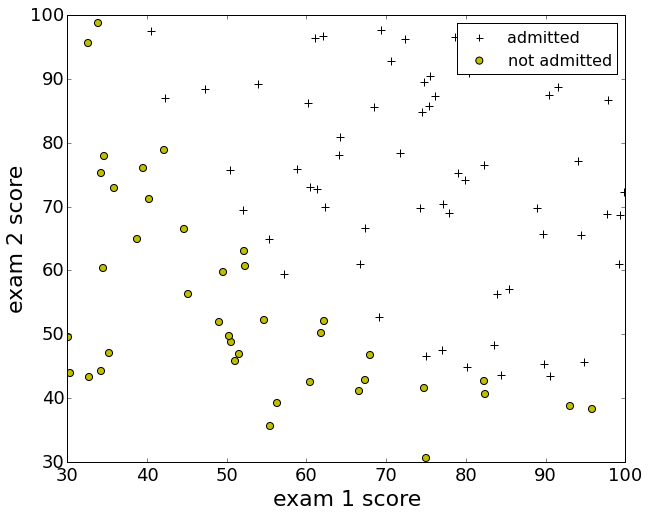

In [4]:
df_pass = df[df.admit==1]
df_fail = df[df.admit==0]
plt.scatter(df_pass.exam1, df_pass.exam2, c='k', marker='+', label='admitted'    , s=50)
plt.scatter(df_fail.exam1, df_fail.exam2, c='y', marker='o', label='not admitted', s=50)
plt.axis([30, 100, 30, 100])
plt.xlabel('exam 1 score')
plt.ylabel('exam 2 score')
plt.legend(['admitted', 'not admitted'], scatterpoints=1)
plt.show()

#### prepare inputs

**recall:** 
* rows $\rightarrow$ training dimension
* cols $\rightarrow$ feature dimension

In [5]:
y = np.asmatrix(df.admit.values).T
m = y.shape[0]
m, y[0:5,:]

(100, matrix([[0],
         [0],
         [0],
         [1],
         [1]]))

In [6]:
X = np.append(np.ones_like(y), np.asmatrix(df[['exam1', 'exam2']]), axis=1)
n = X.shape[1]
n, X[0:5, :]

(3, matrix([[  1.    ,  34.6237,  78.0247],
         [  1.    ,  30.2867,  43.895 ],
         [  1.    ,  35.8474,  72.9022],
         [  1.    ,  60.1826,  86.3086],
         [  1.    ,  79.0327,  75.3444]]))

In [7]:
theta0 = np.matrix(np.zeros((1,n)))
theta0

matrix([[ 0.,  0.,  0.]])

## sigmoid function

Recall that the hypothesis for logicstic regress is defined as

\begin{align}
    h_{\theta} = g\left({\bf \theta}^T {\bf x}\right)
\end{align}

where the function g is the sigmoid function:

\begin{align}
    g(z) = \frac{1}{1 + e^{-z}}
\end{align}

In [8]:
def g(z):
    return 1.0/(1 + np.exp(-z))

In [9]:
g(-100), g(0), g(100)

(3.7200759760208356e-44, 0.5, 1.0)

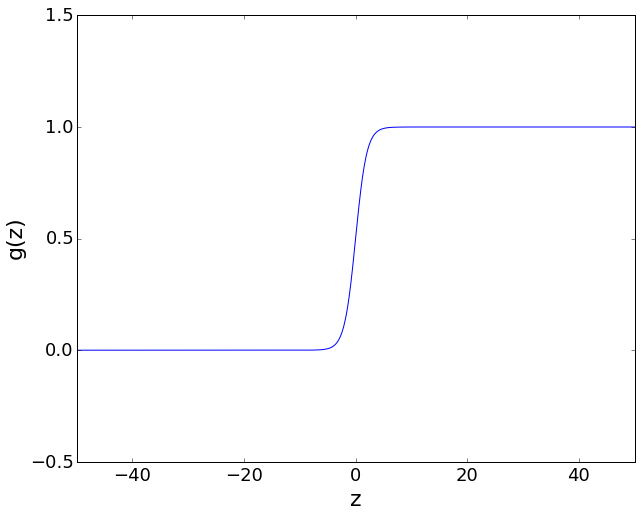

In [10]:
z = np.linspace(-50,50, 1000)
plt.plot(z, g(z))
plt.axis([-50, 50, -0.5, 1.5])
plt.xlabel("z")
plt.ylabel("g(z)")

## cost function

Recall the cost function for logistic regression is given by:

\begin{align}
    J(\theta) &= \frac{1}{2m} \sum_{i=1}^{m} \left( h_{\theta}(x^{(i)}) - y^{(i)} \right)^2 \\
              &= \frac{1}{2m} \sum_{i=1}^{m} \left( \frac{1}{1 + e^{{\bf \theta}^T{\bf x}^{(i)}}} - y^{(i)} \right)^2
\end{align}

which can be rewritten as:

\begin{align}
    J(\theta) &= \frac{1}{m} \sum_{i=1}^{m} \left[-y^{(i)}\log\left\{h_{\theta}(x^{(i)})\right\} - (1 - y^{(i)})\log\left\{1 - h_{\theta}(x^{(i)})\right\} \right]
\end{align}

When implementing the cost function, we also evaluate the gradient in oder to update theta for each iteration:

\begin{align}
    {\bf \theta} &\leftarrow {\bf \theta} - \alpha \nabla_{\theta} J(\theta) \\
\end{align}

To evaluate $\nabla_{\theta} J(\theta)$ and simplify the calculation:

let $z = {\bf \theta}^T {\bf x}$

Also, 

\begin{align}
    \frac{d}{dz}g(z) 
    &= \frac{d}{dz}\left\{\frac{1}{1 + e^{-z}}\right\} \\
    &= \frac{e^{-z}}{(1 + e^{-z})^2} \\
    &= g^2(e^{-z}) \\
    &= g^2(1 - 1 + e^{-z}) \\
    &= g^2(\frac{1}{g} - 1) \\
    &= g(z)(1 - g(z)) \\
\end{align}

so,

\begin{align}
    \frac{\partial}{\partial \theta_f} J(\theta)
    &= \frac{\partial}{\partial \theta_f} \frac{1}{m} \sum_{i=1}^{m} \left[-y^{(i)}\log\left\{g(z^{(i)})\right\} - (1 - y^{(i)})\log\left\{1 - g(z^{(i)})\right\} \right] \\
    &= \frac{1}{m} \sum_{i=1}^{m} \frac{\partial}{\partial \theta_f} \left[-y^{(i)}\log\left\{g(z^{(i)})\right\} - (1 - y^{(i)})\log\left\{1 - g(z^{(i)})\right\} \right] \\
\end{align}

suppressing the superscript $i$ for the moment, consider the argument of the summation over $i$:

\begin{align}
    &= \frac{\partial}{\partial \theta_f} \left[-y\log\left\{g(z))\right\} - (1 - y)\log\left\{1 - g(z)\right\} \right] \\
    &= -y \frac{1}{g} \frac{dg}{dz}\frac{\partial z}{\partial \theta_j} - (1 - y)\left\{\frac{1}{1-g}\right\}(-1)\frac{\partial z}{\partial \theta_j}\frac{\partial z}{\partial \theta_j} \\
    &= (-y (1 - g) + (1 - y)g) \left\{\frac{1}{g(1-g)}\right\} \frac{dg}{dz}\frac{\partial z}{\partial \theta_j} \\
    &= (-y (1 - g) + (1 - y)g) \left\{\frac{1}{g(1-g)}\right\} \left\{g(1-g)\right\}\sum_{k}\frac{\partial}{\partial \theta_k}{\theta_f x_f} \\ 
    &= (g - y)x_f
\end{align}

Returning to full equation, we get:

\begin{align}
    \frac{\partial}{\partial \theta_f} J(\theta)
    &= \frac{1}{m} \sum_{i=1}^{m} \left( h_{\theta}({\bf x}^{(i)}) - y^{(i)} \right) x_{f}^{(i)} \\
\end{align}

In [11]:
def h(theta, X):
    X = np.asmatrix(X)
    theta = np.asmatrix(theta)
    return g(X*theta.T)

In [12]:
def cost(theta, X, y):
    m = len(y) # size of training set
    X = np.asmatrix(X)
    y = np.asmatrix(y)
    theta = np.asmatrix(theta)
    return (1.0/m) * np.sum(-y.T * np.log(h(theta, X)) - (1-y).T*np.log(1 - h(theta,X)))

In [13]:
def grad(theta, X, y):
    m      = len(y) # size of training set
    X      = np.asmatrix(X)
    y      = np.asmatrix(y)
    theta  = np.asmatrix(theta)
    beta   = h(theta, X) - y
    result = (1.0/m)*beta.T*X
    return result

In [14]:
cost(theta0, X, y), grad(theta0, X, y)

(0.69314718055994518, matrix([[ -0.1   , -12.0092, -11.2628]]))

In [15]:
# grad_wrap = lambda theta : grad(theta, X, y)
# cost_wrap = lambda theta : cost(theta, X, y)
# op.check_grad(cost_wrap, grad_wrap, theta0)

## Learning the parameters using scipy.optimize

The octave function to use is **fminunc**.  We'll use the scipy equivelant **scipy.optimize.fmin**.

In [16]:
result = op.minimize(fun=cost, x0=theta0, args=(X,y), method='TNC', jac=grad)
theta_fit = result.x
theta_fit 

array([-25.1613,   0.2062,   0.2015])

In [17]:
cost_fit = cost(theta_fit, X, y)
cost_fit

0.20349770158947483

The value of 0.203 is the correct answer

## Evaluating the logistic regression

In [18]:
def predict(theta, X, threshold=0.5):
    p = h(theta, X)
    return np.where(p > threshold, 1, 0)    

In [19]:
# test single point
predict(theta_fit, np.matrix([1.0, 45, 85]))[0,0]

1

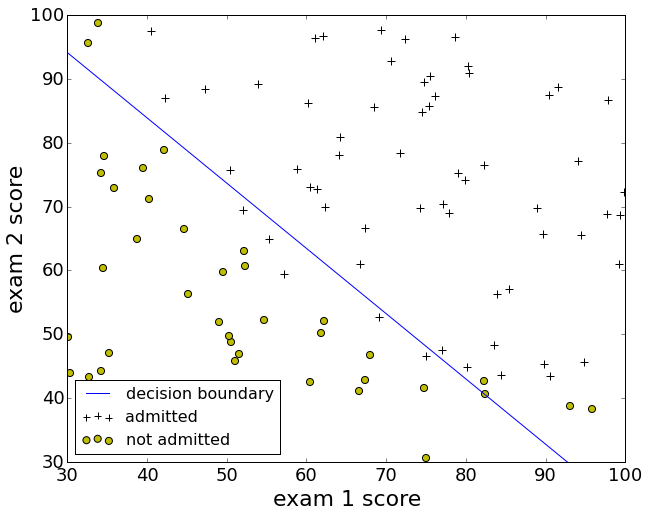

In [20]:
# plot fit
plot_x = np.array([np.min(X[:,1]), np.max(X[:,1])])
t0     = theta_fit[0]
t1     = theta_fit[1]
t2     = theta_fit[2]
plot_y = (-1.0/t2)*(t1*plot_x + t0)
plot_x, plot_y

df_pass = df[df.admit==1]
df_fail = df[df.admit==0]
plt.scatter(df_pass.exam1, df_pass.exam2, c='k', marker='+', s=50)
plt.scatter(df_fail.exam1, df_fail.exam2, c='y', marker='o', s=50)
plt.plot(plot_x, plot_y, 'b')
plt.axis([30, 100, 30, 100])
plt.xlabel('exam 1 score')
plt.ylabel('exam 2 score')
plt.legend(['decision boundary', 'admitted', 'not admitted'], loc='lower left')
plt.show()

The accuracy of our prediction on the training set (the in sample error) is:

In [21]:
p   = predict(theta_fit, X)
acc = np.mean(p==y)*100
print('Training accuracy = %1.2f' % acc)

Training accuracy = 89.00


## Regularized Logistic Regression

In this part of the exercise, you will implement regularized logistic regression to predict whether microchips from a fabrication plant passes quality assurance standards (QA).  During QA, each microchip goes through various tests to ensure it is functioning correcty.

Suppose you are the product manager of the factory and you have the test results for some microchips on two different tests.  From those two tests, you would like to dtermine whether the microchips should be accepted or rejected.

### visualize the data

#### load the data

In [22]:
df = pd.read_csv('ex2data2.txt', names=['test1', 'test2', 'accepted'])
df.head()

,test1,test2,accepted
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


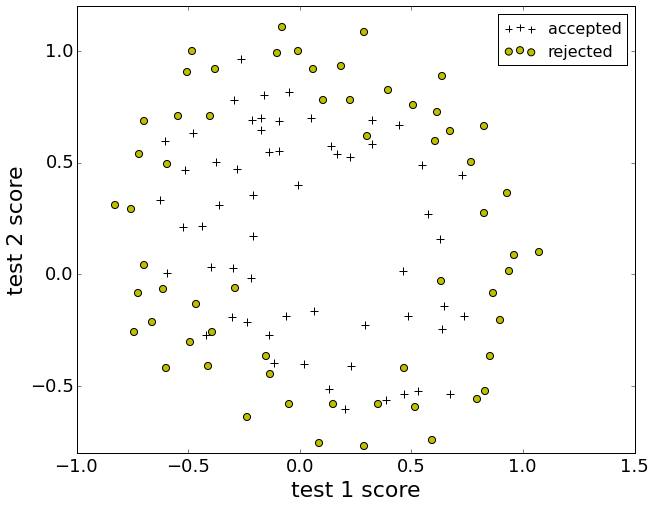

In [23]:
df_pass = df[df.accepted==1]
df_fail = df[df.accepted==0]
plt.scatter(df_pass.test1, df_pass.test2, c='k', marker='+', label='accepted', s=50)
plt.scatter(df_fail.test1, df_fail.test2, c='y', marker='o', label='rejected', s=50)
plt.axis([-1, 1.5, -0.8, 1.2])
plt.xlabel('test 1 score')
plt.ylabel('test 2 score')
plt.legend()
plt.show()

### Feature mapping

This dataset cannot be classified by a linear function (not linearly seperable).  Linear logistic regression will not work.  We will need to create more features form each data point.

Let us construct a feature map of all polynomials of $x_1$ and $x_2$ up the sixth power:

\begin{align}
{\rm map}({\bf x}) = 
\left[
\begin{array}{c}
1 \\
x_1 \\
x_2 \\
x_1^2 \\
x_1x_2 \\
x_2^2 \\
x_1^3 \\
\vdots \\
x_1x_2^4 \\
x_2^6 \\
\end{array} 
\right]
\end{align}

In [24]:
def map_features(x1, x2, degree=6):
    assert(x1.shape == x2.shape)   
    result = np.matrix(np.empty((x1.shape[0], np.sum(np.arange(degree+1)+1))))

    col = 0
    for order in np.arange(degree+1):
        for i in np.arange(order+1):
            j = order-i
            result[:,col] = np.multiply(np.power(x1, i), np.power(x2, j))
            col += 1
    return result

In [25]:
x1 = np.matrix([[2],[3]])
x2 = np.matrix([[2],[4]])
r = map_features(x1, x2)
r

matrix([[  1.0000e+00,   2.0000e+00,   2.0000e+00,   4.0000e+00,
           4.0000e+00,   4.0000e+00,   8.0000e+00,   8.0000e+00,
           8.0000e+00,   8.0000e+00,   1.6000e+01,   1.6000e+01,
           1.6000e+01,   1.6000e+01,   1.6000e+01,   3.2000e+01,
           3.2000e+01,   3.2000e+01,   3.2000e+01,   3.2000e+01,
           3.2000e+01,   6.4000e+01,   6.4000e+01,   6.4000e+01,
           6.4000e+01,   6.4000e+01,   6.4000e+01,   6.4000e+01],
        [  1.0000e+00,   4.0000e+00,   3.0000e+00,   1.6000e+01,
           1.2000e+01,   9.0000e+00,   6.4000e+01,   4.8000e+01,
           3.6000e+01,   2.7000e+01,   2.5600e+02,   1.9200e+02,
           1.4400e+02,   1.0800e+02,   8.1000e+01,   1.0240e+03,
           7.6800e+02,   5.7600e+02,   4.3200e+02,   3.2400e+02,
           2.4300e+02,   4.0960e+03,   3.0720e+03,   2.3040e+03,
           1.7280e+03,   1.2960e+03,   9.7200e+02,   7.2900e+02]])

### cost function and gradient

Now implement the cost function and gradient for the regularized logistic regression.  Recall that a quadratic term in $\theta_j$ is used to "penalize" features -- almost like a damping term in the gradient descent.  The cost function becomes:

\begin{align}
    J(\theta) &= \frac{1}{m} \sum_{i=1}^{m} \left[-y^{(i)}\log\left\{h_{\theta}(x^{(i)})\right\} - (1 - y^{(i)})\log\left\{1 - h_{\theta}(x^{(i)})\right\} \right] + \frac{\lambda}{2m}\sum_{f=1}^{n}\theta_f^2
\end{align}

and the gradient is now:

\begin{align}
\begin{array}{cc}
    \frac{\partial}{\partial \theta_0} J(\theta)
    = \frac{1}{m} \sum_{i=1}^{m} \left( h_{\theta}({\bf x}^{(i)}) - y^{(i)} \right) x_{f}^{(i)} & {\text,\ for\ }f = 0 \\
    \frac{\partial}{\partial \theta_f} J(\theta)
    = \frac{1}{m} \sum_{i=1}^{m} \left( h_{\theta}({\bf x}^{(i)}) - y^{(i)} \right) x_{f}^{(i)} + \frac{\lambda}{m}\theta_j & {\text,\ for\ }f \neq 0 \\
\end{array}
\end{align}

In [26]:
def cost(theta, X, y, lambda_param):
    m = len(y) # size of training set
    X = np.asmatrix(X)
    y = np.asmatrix(y)
    theta = np.asmatrix(theta)
    return (1.0/m) * np.sum(-y.T * np.log(h(theta, X)) - (1-y).T*np.log(1 - h(theta,X))) + (lambda_param/(2*m))*np.sum(np.power(theta[1:],2))

In [27]:
def grad(theta, X, y, lambda_param):
    m = len(y) # size of training set
    X = np.asmatrix(X)
    y = np.asmatrix(y)
    theta = np.asmatrix(theta)    
    return (1.0/m)*(h(theta, X) - y).T*X + (lambda_param/(m))*np.concatenate((np.zeros_like(theta[:,0]),theta[:,1:]), axis=1)

### prepare inputs

In [28]:
y = np.asmatrix(df.accepted.values).T
m = y.shape[0]
m, y[0:5,:]

(118, matrix([[1],
         [1],
         [1],
         [1],
         [1]]))

In [29]:
x1 = np.asmatrix(df.test1.values).T
x2 = np.asmatrix(df.test2.values).T
X = map_features(x1, x2)
n = X.shape[1]
n, X[0:2, :]

(28, matrix([[  1.0000e+00,   6.9956e-01,   5.1267e-02,   4.8938e-01,
            3.5864e-02,   2.6283e-03,   3.4235e-01,   2.5089e-02,
            1.8387e-03,   1.3475e-04,   2.3950e-01,   1.7551e-02,
            1.2863e-03,   9.4262e-05,   6.9080e-06,   1.6754e-01,
            1.2278e-02,   8.9981e-04,   6.5942e-05,   4.8326e-06,
            3.5415e-07,   1.1721e-01,   8.5894e-03,   6.2947e-04,
            4.6131e-05,   3.3807e-06,   2.4775e-07,   1.8156e-08],
         [  1.0000e+00,   6.8494e-01,  -9.2742e-02,   4.6914e-01,
           -6.3523e-02,   8.6011e-03,   3.2133e-01,  -4.3509e-02,
            5.8912e-03,  -7.9768e-04,   2.2009e-01,  -2.9801e-02,
            4.0351e-03,  -5.4636e-04,   7.3979e-05,   1.5075e-01,
           -2.0412e-02,   2.7638e-03,  -3.7423e-04,   5.0671e-05,
           -6.8609e-06,   1.0326e-01,  -1.3981e-02,   1.8931e-03,
           -2.5632e-04,   3.4707e-05,  -4.6993e-06,   6.3630e-07]]))

In [30]:
theta0 = np.asmatrix(np.zeros((1,n)))
theta0

matrix([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.]])

### optimize 

In [31]:
result_l1   = op.minimize(fun=cost, x0=theta0, args=(X,y,1.0  ), method='TNC', jac=grad)
result_l0   = op.minimize(fun=cost, x0=theta0, args=(X,y,0.0  ), method='TNC', jac=grad)
result_l100 = op.minimize(fun=cost, x0=theta0, args=(X,y,100.0), method='TNC', jac=grad)

In [32]:
theta_l1_fit   = result_l1.x
theta_l0_fit   = result_l0.x
theta_l100_fit = result_l100.x
theta_l1_fit

array([ 1.2742,  1.1859,  0.6248, -1.4132, -0.9171, -2.0217, -0.1807,
       -0.3646, -0.3677,  0.1244, -1.2013, -0.2717, -0.62  , -0.0629,
       -1.4651, -0.4679, -0.2928, -0.278 , -0.0549, -0.209 , -0.2366,
       -0.9355, -0.138 , -0.3292,  0.0096, -0.2964,  0.0208, -1.044 ])

In [33]:
# contour of decision boundary
u = np.linspace(-1, 1.5, 50)
v = u.copy()
z_l1   = np.zeros((len(u), len(v)))
z_l0   = np.zeros((len(u), len(v)))
z_l100 = np.zeros((len(u), len(v)))

for i, u_value in enumerate(u):
    for j, v_value in enumerate(v):
        u_value      = np.asmatrix(u_value).T
        v_value      = np.asmatrix(v_value).T
        z_l1  [i, j] = theta_l1_fit*map_features(u_value, v_value).T
        z_l0  [i, j] = theta_l0_fit*map_features(u_value, v_value).T
        z_l100[i, j] = theta_l100_fit*map_features(u_value, v_value).T

z_l1   = z_l1.T
z_l0   = z_l0.T
z_l100 = z_l100.T

/usr/local/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):


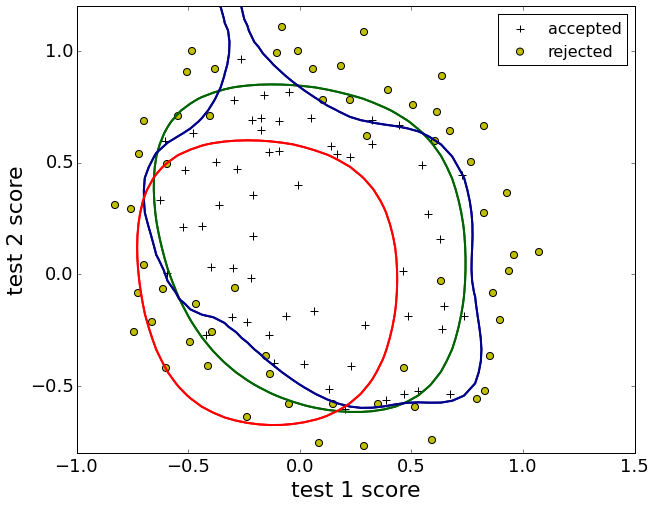

In [34]:
df_pass = df[df.accepted==1]
df_fail = df[df.accepted==0]
plt.scatter(df_pass.test1, df_pass.test2, c='k', marker='+', s=50)
plt.scatter(df_fail.test1, df_fail.test2, c='y', marker='o', s=50)
c1 = plt.contour(u, v, z_l1  , colors=['darkgreen'], levels=[0,0], linewidths=[2])
c2 = plt.contour(u, v, z_l0  , colors=['darkblue' ], levels=[0,0], linewidths=[2])
c3 = plt.contour(u, v, z_l100, colors=['red'      ], levels=[0,0], linewidths=[2])
plt.axis([-1, 1.5, -0.8, 1.2])
plt.xlabel('test 1 score')
plt.ylabel('test 2 score')
# plt.legend(['accepted', 'rejected', '$\\lambda$ = 1', '$\\lambda$ = 0', '$\\lambda$ = 100'], scatterpoints=1)
plt.legend(['accepted', 'rejected', '$\\lambda$ = 1', '$\\lambda$ = 0', '$\\lambda$ = 100'], scatterpoints=1)
plt.show()